In [ ]:
!pip install mediapipe opencv-python numpy


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


In [ ]:
# Landmarks
def extract_landmarks_from_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"No se puede cargar la imagen: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mp_pose = mp.solutions.pose
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
        result = pose.process(img_rgb)
        if result.pose_landmarks:
            keypoints = []
            for lm in result.pose_landmarks.landmark:
                keypoints.append([lm.x, lm.y, lm.z])
            return keypoints
        else:
            return None


# Cálculo de ángulos
def calc_angle(a, b, c):
    """Calcula el ángulo en el punto b formado por los puntos a-b-c"""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)



In [ ]:
# Ángulos articulares almancenados
class AngleTracker:
    def __init__(self):
        self.data = {
            # Piernas
            'rodilla_derecha': [],
            'rodilla_izquierda': [],
            'tobillo_derecho': [],
            'tobillo_izquierdo': [],
            'cadera_derecha': [],
            'cadera_izquierda': [],

            # Brazos
            'codo_derecho': [],
            'codo_izquierdo': [],
            'muñeca_derecha': [],
            'muñeca_izquierda': [],
            'hombro_derecho': [],
            'hombro_izquierdo': [],

            # Frame tracking
            'frame': []
        }

    def add_frame(self, frame_idx, keypoints):
        """Calcula y almacena todos los ángulos para un frame"""
        self.data['frame'].append(frame_idx)

        # Piernas - Rodillas (cadera-rodilla-tobillo)
        self.data['rodilla_derecha'].append(
            calc_angle(keypoints[24], keypoints[26], keypoints[28]))
        self.data['rodilla_izquierda'].append(
            calc_angle(keypoints[23], keypoints[25], keypoints[27]))

        # Piernas - Tobillos (rodilla-tobillo-pie)
        self.data['tobillo_derecho'].append(
            calc_angle(keypoints[26], keypoints[28], keypoints[32]))
        self.data['tobillo_izquierdo'].append(
            calc_angle(keypoints[25], keypoints[27], keypoints[31]))

        # Piernas - Caderas (hombro-cadera-rodilla)
        self.data['cadera_derecha'].append(
            calc_angle(keypoints[12], keypoints[24], keypoints[26]))
        self.data['cadera_izquierda'].append(
            calc_angle(keypoints[11], keypoints[23], keypoints[25]))

        # Brazos - Codos (hombro-codo-muñeca)
        self.data['codo_derecho'].append(
            calc_angle(keypoints[12], keypoints[14], keypoints[16]))
        self.data['codo_izquierdo'].append(
            calc_angle(keypoints[11], keypoints[13], keypoints[15]))

        # Brazos - Muñecas (codo-muñeca-índice)
        self.data['muñeca_derecha'].append(
            calc_angle(keypoints[14], keypoints[16], keypoints[20]))
        self.data['muñeca_izquierda'].append(
            calc_angle(keypoints[13], keypoints[15], keypoints[19]))

        # Brazos - Hombros (cadera-hombro-codo)
        self.data['hombro_derecho'].append(
            calc_angle(keypoints[24], keypoints[12], keypoints[14]))
        self.data['hombro_izquierdo'].append(
            calc_angle(keypoints[23], keypoints[11], keypoints[13]))

    def get_dataframe(self):
        """Retorna los datos como DataFrame de pandas"""
        return pd.DataFrame(self.data)

    def save_to_csv(self, filename="angulos_completos.csv"):
        """Guarda todos los datos en un archivo CSV"""
        df = self.get_dataframe()
        df.to_csv(filename, index=False)
        print(f"✓ Datos guardados en {filename}")
        return df

In [ ]:
# Dibujo de esqueleto
def draw_skeleton(frame, keypoints, img_shape):
    """Dibuja conexiones de huesos entre articulaciones"""
    h, w, _ = img_shape

    # Definir conexiones (huesos)
    connections = [
        # Torso
        (11, 12), (11, 23), (12, 24), (23, 24),

        # Brazo derecho
        (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),

        # Brazo izquierdo
        (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),

        # Pierna derecha
        (24, 26), (26, 28), (28, 30), (28, 32),

        # Pierna izquierda
        (23, 25), (25, 27), (27, 29), (27, 31),

        # Cabeza
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8)
    ]

    # Dibujar huesos (líneas)
    for start_idx, end_idx in connections:
        if start_idx < len(keypoints) and end_idx < len(keypoints):
            start = keypoints[start_idx]
            end = keypoints[end_idx]

            start_point = (int(start[0] * w), int(start[1] * h))
            end_point = (int(end[0] * w), int(end[1] * h))

            # Línea gruesa para simular hueso
            cv2.line(frame, start_point, end_point, (255, 200, 100), 3)

    # Dibujar articulaciones (círculos)
    for idx, kp in enumerate(keypoints):
        x, y = int(kp[0] * w), int(kp[1] * h)
        # Articulaciones principales más grandes
        if idx in [11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]:
            cv2.circle(frame, (x, y), 6, (0, 255, 0), -1)
            cv2.circle(frame, (x, y), 6, (0, 0, 0), 2)
        else:
            cv2.circle(frame, (x, y), 4, (0, 200, 255), -1)


In [ ]:
# Imagen en posición T
tpose_image_path = "/media/Tpose.jpg"
reference_frame = extract_landmarks_from_image(tpose_image_path)
if reference_frame is None:
    raise ValueError("Error: posición T no detectada en la imagen suministrada")

print("✓ Posición T de referencia cargada correctamente")


# Track de ángulos
angle_tracker = AngleTracker()


# Procesamiento de video
video_path = "/media/input.mp4"
cap = cv2.VideoCapture(video_path)
mp_pose = mp.solutions.pose

print(f"\nProcesando video: {video_path}")
print("=" * 50)

with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5) as pose:
    frame_index = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(img_rgb)

        if results.pose_landmarks:
            # Obtener los puntos
            keypoints = []
            for lm in results.pose_landmarks.landmark:
                keypoints.append([lm.x, lm.y, lm.z])

            # Verificar detección completa
            if len(keypoints) >= 33:  # MediaPipe Pose tiene 33 landmarks
                # Registrar ángulos
                angle_tracker.add_frame(frame_index, keypoints)

                # Dibujar esqueleto personalizado
                draw_skeleton(frame, keypoints, frame.shape)

                # Obtener últimos ángulos calculados
                last_idx = len(angle_tracker.data['frame']) - 1

                # Mostrar información en pantalla
                y_offset = 30
                info_text = [
                    f"Frame: {frame_index}",
                    f"Rodilla D: {angle_tracker.data['rodilla_derecha'][last_idx]:.1f}",
                    f"Rodilla I: {angle_tracker.data['rodilla_izquierda'][last_idx]:.1f}",
                    f"Tobillo D: {angle_tracker.data['tobillo_derecho'][last_idx]:.1f}",
                    f"Tobillo I: {angle_tracker.data['tobillo_izquierdo'][last_idx]:.1f}",
                    f"Codo D: {angle_tracker.data['codo_derecho'][last_idx]:.1f}",
                    f"Muñeca D: {angle_tracker.data['muñeca_derecha'][last_idx]:.1f}"
                ]

                for i, text in enumerate(info_text):
                    cv2.putText(frame, text, (10, y_offset + i*25),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

        # Visualización
        cv2_imshow(frame)

        if cv2.waitKey(1) & 0xFF == 27:
            break

        frame_index += 1

cap.release()
cv2.destroyAllWindows()

print(f"\nProcesamiento completado: {frame_index} frames analizados")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# --- Guardar datos unificados ---
print("\nGuardando datos unificados...")
df_completo = angle_tracker.save_to_csv("angulos_completos.csv")


Guardando datos unificados...
✓ Datos guardados en angulos_completos.csv



ANÁLISIS ESTADÍSTICO DE ÁNGULOS

PIERNAS:

Rodilla Derecha:
  • Mínimo: 48.37°
  • Máximo: 170.68°
  • Amplitud: 122.31°
  • Media: 128.96°
  • Mediana: 129.93°
  • Desv. Est.: 20.89°

Rodilla Izquierda:
  • Mínimo: 77.50°
  • Máximo: 173.96°
  • Amplitud: 96.45°
  • Media: 134.81°
  • Mediana: 138.04°
  • Desv. Est.: 22.45°

Tobillo Derecho:
  • Mínimo: 36.17°
  • Máximo: 100.09°
  • Amplitud: 63.92°
  • Media: 63.17°
  • Mediana: 63.47°
  • Desv. Est.: 12.16°

Tobillo Izquierdo:
  • Mínimo: 36.09°
  • Máximo: 130.08°
  • Amplitud: 93.99°
  • Media: 62.19°
  • Mediana: 61.08°
  • Desv. Est.: 12.64°

BRAZOS:

Codo Derecho:
  • Mínimo: 52.87°
  • Máximo: 179.11°
  • Amplitud: 126.24°
  • Media: 108.73°
  • Mediana: 102.68°
  • Desv. Est.: 30.49°

Codo Izquierdo:
  • Mínimo: 58.72°
  • Máximo: 163.29°
  • Amplitud: 104.57°
  • Media: 101.41°
  • Mediana: 99.78°
  • Desv. Est.: 26.49°

Muñeca Derecha:
  • Mínimo: 90.51°
  • Máximo: 178.09°
  • Amplitud: 87.58°
  • Media: 147.92°
  • Medi

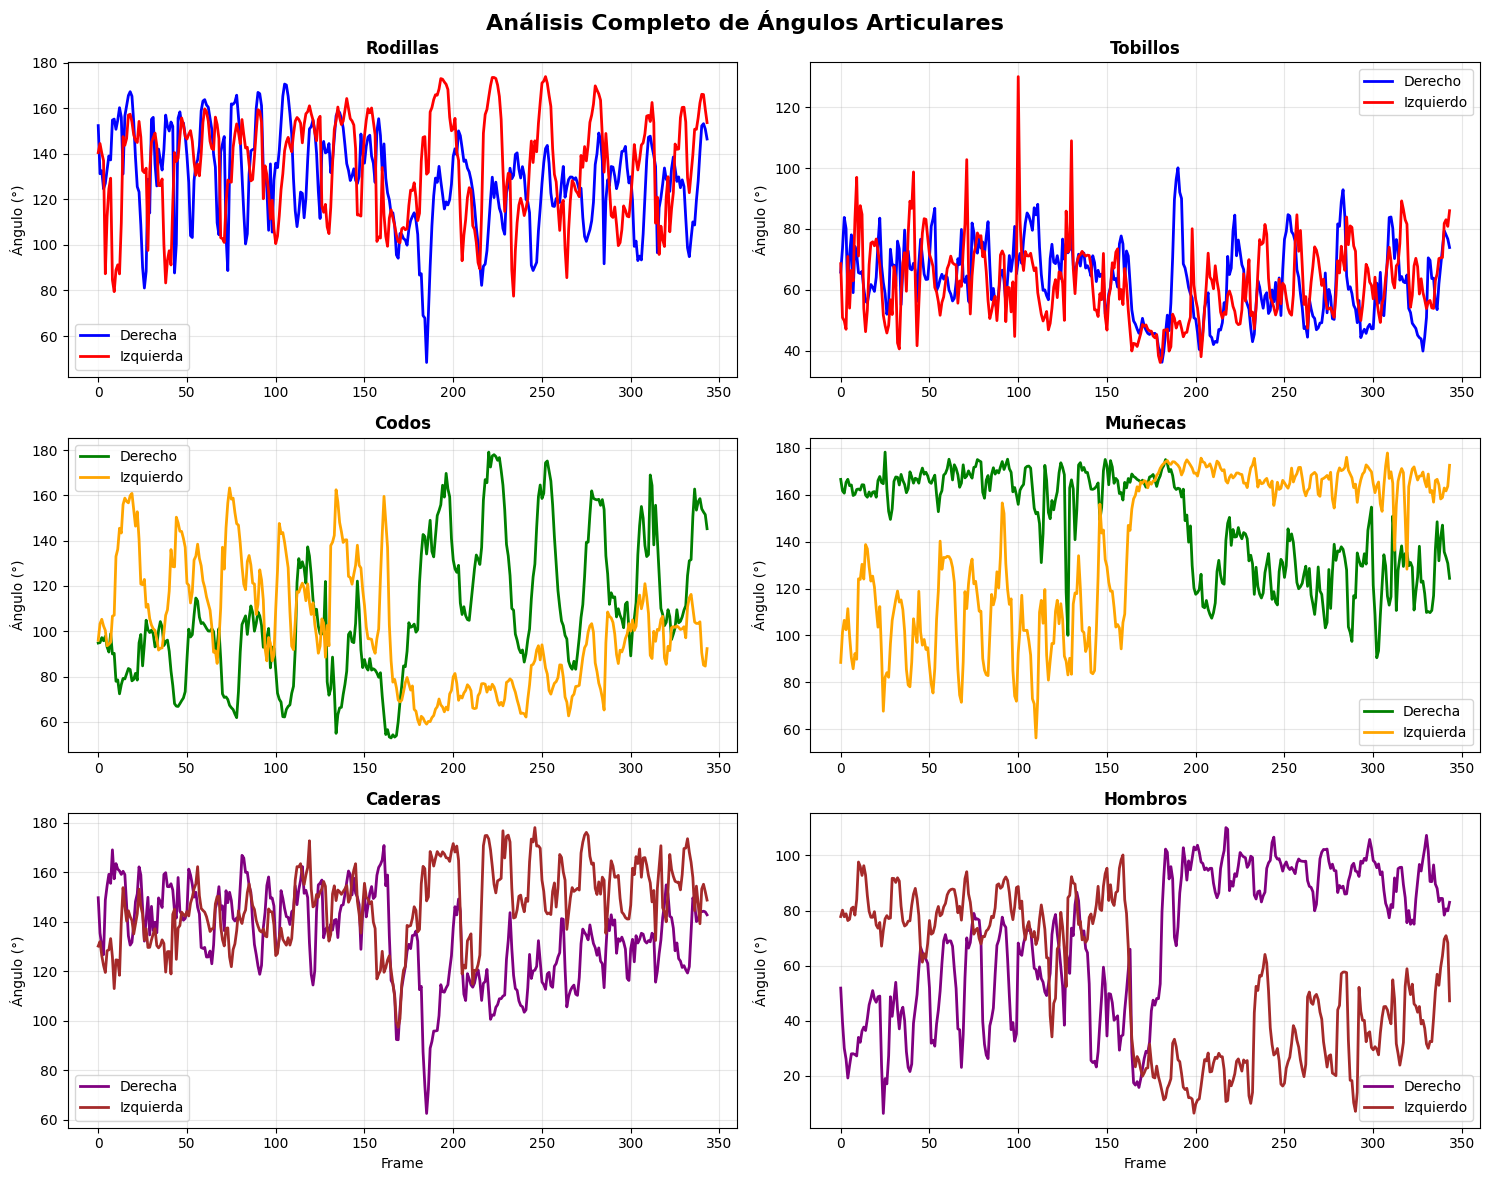

✓ Visualización guardada como 'analisis_completo_articulaciones.png'

Análisis completado exitosamente!


In [ ]:
# Datos extraídos
print("\n" + "=" * 50)
print("ANÁLISIS ESTADÍSTICO DE ÁNGULOS")
print("=" * 50)

def analizar_articulacion(df, columna, nombre):
    """Análisis detallado de una articulación"""
    datos = df[columna]
    print(f"\n{nombre}:")
    print(f"  • Mínimo: {datos.min():.2f}°")
    print(f"  • Máximo: {datos.max():.2f}°")
    print(f"  • Amplitud: {datos.max() - datos.min():.2f}°")
    print(f"  • Media: {datos.mean():.2f}°")
    print(f"  • Mediana: {datos.median():.2f}°")
    print(f"  • Desv. Est.: {datos.std():.2f}°")

# Análisis por grupos
print("\nPIERNAS:")
analizar_articulacion(df_completo, 'rodilla_derecha', 'Rodilla Derecha')
analizar_articulacion(df_completo, 'rodilla_izquierda', 'Rodilla Izquierda')
analizar_articulacion(df_completo, 'tobillo_derecho', 'Tobillo Derecho')
analizar_articulacion(df_completo, 'tobillo_izquierdo', 'Tobillo Izquierdo')

print("\nBRAZOS:")
analizar_articulacion(df_completo, 'codo_derecho', 'Codo Derecho')
analizar_articulacion(df_completo, 'codo_izquierdo', 'Codo Izquierdo')
analizar_articulacion(df_completo, 'muñeca_derecha', 'Muñeca Derecha')
analizar_articulacion(df_completo, 'muñeca_izquierda', 'Muñeca Izquierda')


# Gráficos
# Figura 1: Todas las articulaciones
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Análisis Completo de Ángulos Articulares', fontsize=16, fontweight='bold')

# Rodillas
axes[0, 0].plot(df_completo['frame'], df_completo['rodilla_derecha'],
                label='Derecha', color='blue', linewidth=2)
axes[0, 0].plot(df_completo['frame'], df_completo['rodilla_izquierda'],
                label='Izquierda', color='red', linewidth=2)
axes[0, 0].set_title('Rodillas', fontweight='bold')
axes[0, 0].set_ylabel('Ángulo (°)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Tobillos
axes[0, 1].plot(df_completo['frame'], df_completo['tobillo_derecho'],
                label='Derecho', color='blue', linewidth=2)
axes[0, 1].plot(df_completo['frame'], df_completo['tobillo_izquierdo'],
                label='Izquierdo', color='red', linewidth=2)
axes[0, 1].set_title('Tobillos', fontweight='bold')
axes[0, 1].set_ylabel('Ángulo (°)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Codos
axes[1, 0].plot(df_completo['frame'], df_completo['codo_derecho'],
                label='Derecho', color='green', linewidth=2)
axes[1, 0].plot(df_completo['frame'], df_completo['codo_izquierdo'],
                label='Izquierdo', color='orange', linewidth=2)
axes[1, 0].set_title('Codos', fontweight='bold')
axes[1, 0].set_ylabel('Ángulo (°)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Muñecas
axes[1, 1].plot(df_completo['frame'], df_completo['muñeca_derecha'],
                label='Derecha', color='green', linewidth=2)
axes[1, 1].plot(df_completo['frame'], df_completo['muñeca_izquierda'],
                label='Izquierda', color='orange', linewidth=2)
axes[1, 1].set_title('Muñecas', fontweight='bold')
axes[1, 1].set_ylabel('Ángulo (°)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Caderas
axes[2, 0].plot(df_completo['frame'], df_completo['cadera_derecha'],
                label='Derecha', color='purple', linewidth=2)
axes[2, 0].plot(df_completo['frame'], df_completo['cadera_izquierda'],
                label='Izquierda', color='brown', linewidth=2)
axes[2, 0].set_title('Caderas', fontweight='bold')
axes[2, 0].set_xlabel('Frame')
axes[2, 0].set_ylabel('Ángulo (°)')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Hombros
axes[2, 1].plot(df_completo['frame'], df_completo['hombro_derecho'],
                label='Derecho', color='purple', linewidth=2)
axes[2, 1].plot(df_completo['frame'], df_completo['hombro_izquierdo'],
                label='Izquierdo', color='brown', linewidth=2)
axes[2, 1].set_title('Hombros', fontweight='bold')
axes[2, 1].set_xlabel('Frame')
axes[2, 1].set_ylabel('Ángulo (°)')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_completo_articulaciones.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualización guardada como 'analisis_completo_articulaciones.png'")
print("\nAnálisis completado exitosamente!")